In [1]:
import os
import cv2
import pickle
from tqdm import tqdm
import pandas as pd 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.15.0


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
pickle_in = open("./data/train_x.pickle","rb")
train_x = pickle.load(pickle_in)

pickle_in = open("./data/train_y.pickle","rb")
train_y = pickle.load(pickle_in)

pickle_in = open("./data/test_x.pickle","rb")
test_x = pickle.load(pickle_in)

pickle_in = open("./data/test_y.pickle","rb")
test_y = pickle.load(pickle_in)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2850, 60, 60, 3)
(2850, 3)
(150, 60, 60, 3)
(150, 3)


In [4]:
num_classes = 3
n_input = 10800
learning_rate = 0.001
training_iters = 10
batch_size = 512
display_step = 20

In [5]:
img_size=60
num_channels=3
x = tf.compat.v1.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels]) 
y_ = tf.compat.v1.placeholder(tf.float32, [None, num_classes])
print('Shape of placeholder',x.shape, y_.shape)

Shape of placeholder (?, 60, 60, 3) (?, 3)


In [6]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool2d(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [7]:
weights = {
    'w1': tf.Variable(tf.random.normal([5, 5, 3, 32]),name='w1'),
    'w2': tf.Variable(tf.random.normal([5, 5, 32, 64]),name='w2'),
    'w3': tf.Variable(tf.random.normal([5, 5, 64, 128]),name='w3'),
    'wd1': tf.Variable(tf.random.normal([8 * 8 * 128, 2048]),name='wd1'),  
    'wout': tf.Variable(tf.random.normal([2048, num_classes]),name='wout')
}

biases = {
    'b1': tf.Variable(tf.random.normal([32]),name='b1'),
    'b2': tf.Variable(tf.random.normal([64]),name='b2'),
    'b3': tf.Variable(tf.random.normal([128]),name='b3'),
    'bd1': tf.Variable(tf.random.normal([2048]),name='bd1'),
    'bout': tf.Variable(tf.random.normal([num_classes]),name='bout')
}

In [8]:
def conv_net(x, weights, biases):
        
    # reshape input to 60x60x3 size
    x = tf.reshape(x, shape=[-1, 60, 60, 3])  
    
    print("----------------------------------------------------------------------------")
    print("size of x is")
    print(x.shape)
    
  
    conv1 = conv2d(x, weights['w1'], biases['b1'])
    conv1 = maxpool2d(conv1, k=2)
    print("----------------------------------------------------------------------------")
    print("size after 1st conv layer is ")
    print(conv1.shape)

    
    #input is 30*30*32 image
    # Convolution Layer
    conv2 = conv2d(conv1, weights['w2'], biases['b2'])
    conv2 = maxpool2d(conv2, k=2)
    print("----------------------------------------------------------------------------")
    print("size after 2nd conv and pooling layer is")
    print(conv2.shape)
    
    
    ### third conv layer
    # input is 15*15*64 image
    # Convolution Layer
    conv3 = conv2d(conv2, weights['w3'], biases['b3'])
  
    conv3 = maxpool2d(conv3, k=2)
    print("----------------------------------------------------------------------------")
    print("size after 3rd conv and pooling layer is")
    print(conv3.shape)
    
    
    
    #input is 8*8*128 
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input   = 8*8*128 = 8192
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    print("----------------------------------------------------------------------------")
    print("shape after flattening the image")
    print(fc1)  #8192 is the output
    
    
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    print("----------------------------------------------------------------------------")
    print("shape after fully connected layer")
    print(fc1)
    
    
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['wout']), biases['bout'])
    print("----------------------------------------------------------------------------")
    print("Output layer")
    return out

In [9]:
model = conv_net(x, weights, biases)
print(model)

----------------------------------------------------------------------------
size of x is
(?, 60, 60, 3)
----------------------------------------------------------------------------
size after 1st conv layer is 
(?, 30, 30, 32)
----------------------------------------------------------------------------
size after 2nd conv and pooling layer is
(?, 15, 15, 64)
----------------------------------------------------------------------------
size after 3rd conv and pooling layer is
(?, 8, 8, 128)
----------------------------------------------------------------------------
shape after flattening the image
Tensor("Reshape_1:0", shape=(?, 8192), dtype=float32)
----------------------------------------------------------------------------
shape after fully connected layer
Tensor("Relu_3:0", shape=(?, 2048), dtype=float32)
----------------------------------------------------------------------------
Output layer
Tensor("Add_1:0", shape=(?, 3), dtype=float32)


In [10]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=y_))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [11]:
init = tf.compat.v1.global_variables_initializer()

In [12]:
cost_history=[]
n_epochs =500

sess = tf.compat.v1.Session()
sess.run(init)
train_y=train_y.todense()
for i in range(n_epochs):
    a, c = sess.run([optimizer, cost], feed_dict={x: train_x, y_: train_y})  
    cost_history = np.append(cost_history,c)  
    print('epoch : ', i, ' - ', 'cost: ', c)

epoch :  0  -  cost:  2113724.5
epoch :  1  -  cost:  5234927.0
epoch :  2  -  cost:  6394567.5
epoch :  3  -  cost:  3789004.8
epoch :  4  -  cost:  2011008.6
epoch :  5  -  cost:  2283783.5
epoch :  6  -  cost:  3383821.2
epoch :  7  -  cost:  2714547.8
epoch :  8  -  cost:  1380910.8
epoch :  9  -  cost:  1104373.8
epoch :  10  -  cost:  1770505.1
epoch :  11  -  cost:  2107695.2
epoch :  12  -  cost:  1823942.1
epoch :  13  -  cost:  1153800.6
epoch :  14  -  cost:  785305.1
epoch :  15  -  cost:  1197712.1
epoch :  16  -  cost:  1480759.2
epoch :  17  -  cost:  1265952.9
epoch :  18  -  cost:  778752.25
epoch :  19  -  cost:  717587.7
epoch :  20  -  cost:  1042699.9
epoch :  21  -  cost:  1084081.1
epoch :  22  -  cost:  830518.0
epoch :  23  -  cost:  635880.56
epoch :  24  -  cost:  735027.4
epoch :  25  -  cost:  857325.06
epoch :  26  -  cost:  781505.3
epoch :  27  -  cost:  577545.3
epoch :  28  -  cost:  572125.06
epoch :  29  -  cost:  709519.75
epoch :  30  -  cost:  652

epoch :  247  -  cost:  1958.0859
epoch :  248  -  cost:  2169.2883
epoch :  249  -  cost:  1786.2786
epoch :  250  -  cost:  1643.6566
epoch :  251  -  cost:  1716.0677
epoch :  252  -  cost:  1680.799
epoch :  253  -  cost:  1435.8857
epoch :  254  -  cost:  1342.4539
epoch :  255  -  cost:  1442.5531
epoch :  256  -  cost:  1208.43
epoch :  257  -  cost:  1163.9067
epoch :  258  -  cost:  1226.9216
epoch :  259  -  cost:  1092.1433
epoch :  260  -  cost:  940.9009
epoch :  261  -  cost:  1058.3712
epoch :  262  -  cost:  856.6427
epoch :  263  -  cost:  840.0449
epoch :  264  -  cost:  846.81885
epoch :  265  -  cost:  803.94586
epoch :  266  -  cost:  725.08374
epoch :  267  -  cost:  667.81805
epoch :  268  -  cost:  673.52814
epoch :  269  -  cost:  603.9089
epoch :  270  -  cost:  560.3801
epoch :  271  -  cost:  547.4823
epoch :  272  -  cost:  519.8914
epoch :  273  -  cost:  484.1307
epoch :  274  -  cost:  462.91623
epoch :  275  -  cost:  433.14233
epoch :  276  -  cost:  4

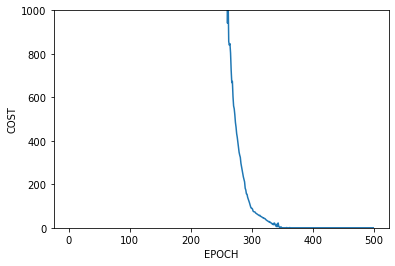

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(0,500), cost_history[0:500])
plt.ylabel('COST')
plt.xlabel('EPOCH')
plt.ylim([0, 1000])
plt.show()

In [14]:
test_y=test_y.todense() 
correct_prediction = tf.equal(tf.argmax(model,1), tf.argmax(y_,1))   
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy: ", sess.run(accuracy, feed_dict={x: test_x, y_:test_y}))

Accuracy:  0.6066667
